# CRAIG+DP attempt
(created on 12/13/2024)

To achieve the project objective of evaluating CRAIG’s performance on private noisy gradients, we
integrate CRAIG and DP into a unified backward pass pipeline:

--------------------------------------------
Link to Opacus: https://opacus.ai/

In [ ]:
!pip install torch torchvision opacus matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.9/239.9 kB 14.1 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.simplefilter("ignore")

In [ ]:
def accuracy(preds, labels):
    return (preds == labels).mean()

## 1. Install and import libraries
Follow these steps to install and import CORDS, Submodlib, and Opacus

### Import CRAIG

In [ ]:
!pip install dotmap
!pip install apricot-select
!pip install ray[default]
!pip install ray[tune]
!pip install datasets
!pip install transformers
!pip install sentence-transformers
!pip install scikit-learn
!pip install wandb

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 14.7 MB/s eta 0:00:00
  Created wheel for apricot-select: filename=apricot_select-0.6.1-py3-none-any.whl size=48766 sha256=2fbf24fc3e2da45950b390571955deb52d0d2d759128a46e7d72d9dc7ae0e866
  Stored in directory: /root/.cache/pip/wheels/df/d8/f9/4d62b7272bff772a126a52e507212c2fd33c0b8416d9389665
Successfully built apricot-select
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

In [ ]:
%cd ..
!git clone https://github.com/decile-team/submodlib.git
%cd submodlib
!pip install .
%cd ../cords

/content
Cloning into 'submodlib'...
remote: Enumerating objects: 2583, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 2583 (delta 8), reused 14 (delta 4), pack-reused 2559 (from 1)
Receiving objects: 100% (2583/2583), 30.58 MiB | 11.46 MiB/s, done.
Resolving deltas: 100% (1917/1917), done.
/content/submodlib
Processing /content/submodlib
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for submodlib: filename=submodlib-1.1.5-cp310-cp310-linux_x86_64.whl size=577257 sha256=2a1de4e3d66456e4d2203a6b6b5ff6f73d0f958de841b8be61f40f2303e32781
  Stored in directory: /tmp/pip-ephem-wheel-cache-ovykb4vs/wheels/38/8a/82/dcc1be631ad42bd42b29737e6f518581c869e8a7e861adfba8
Successfully built submodlib
/content/cords


In [ ]:
import time
import numpy as np
import logging
import os.path as osp
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from cords.utils.data.datasets.SL import gen_dataset
from torch.utils.data import Subset
from cords.utils.config_utils import load_config_data
import os.path as osp
from cords.utils.data.data_utils import WeightedSubset
from ray import tune

## 2. Data and model
- Use the preprocessed MNIST dataset from the CORDS library. Divide the dataset into training and validation sets with a 90%-10% split.
- 2-layer CNN model used here is imported from CORDS library, with the extended methods required for data selection.

In [ ]:
trainset, validset, testset, num_cls = gen_dataset('data/', 'mnist', None, isnumpy=False)

trn_batch_size = 128
val_batch_size = 128
tst_batch_size = 1000

# Creating the Data Loaders

trainloader = torch.utils.data.DataLoader(trainset, batch_size=trn_batch_size,
                                          shuffle=False, pin_memory=True)

valloader = torch.utils.data.DataLoader(validset, batch_size=val_batch_size,
                                        shuffle=False, pin_memory=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=tst_batch_size,
                                              shuffle=False, pin_memory=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.11MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.19MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from cords.utils.models import CNN
model = CNN(10)
model = model.to(device)

In [ ]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
criterion_nored = nn.CrossEntropyLoss(reduction='none')
optimizer = optim.SGD(model.parameters(), lr=5e-2,
                                  momentum=0.9,
                                  weight_decay=5e-4,
                                  nesterov=True)

#T_max is the maximum number of scheduler steps. Here we are using the number of epochs as the maximum number of scheduler steps.

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                       T_max=200)

## 3. Setup private engine
Wrap model, dataloader, and optimizer with the defined level of privacy ($\epsilon , \delta $) preservation.

In [ ]:
from opacus.validators import ModuleValidator

import torch
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 128
MAX_PHYSICAL_BATCH_SIZE = 128

# These values, specific to the MNIST dataset, are assumed to be known.
# If necessary, they can be computed with modest privacy budgets.
MNIST_MEAN = (0.1307)
MNIST_STD_DEV = (0.3081)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MNIST_MEAN, MNIST_STD_DEV),
])

In [ ]:
errors = ModuleValidator.validate(model, strict=False)
errors[-5:]

[]

In [ ]:
# model = ModuleValidator.fix(model)
# ModuleValidator.validate(model, strict=False)

In [ ]:
from opacus import PrivacyEngine

MAX_GRAD_NORM = 0.5
EPSILON = 2
DELTA = 0.5
# DELTA = 1e-4
EPOCHS = 5

LR = 1e-3

privacy_engine = PrivacyEngine()

model_dp, optimizer_dp, trainloader_dp = privacy_engine.make_private_with_epsilon(
    module=model,
    optimizer=optimizer,
    data_loader=trainloader,
    epochs=EPOCHS,
    target_epsilon=EPSILON,
    target_delta=DELTA,
    max_grad_norm=MAX_GRAD_NORM,
)

model_dp.get_embedding_dim = model.get_embedding_dim
print(f"Using sigma={optimizer_dp.noise_multiplier} and C={MAX_GRAD_NORM}")

Using sigma=0.31280517578125 and C=0.5


## 4. Define utility functions for training

In [ ]:
def save_ckpt(state, ckpt_path):
    torch.save(state, ckpt_path)


def load_ckpt(ckpt_path, model, optimizer):
    checkpoint = torch.load(ckpt_path)
    start_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    loss = checkpoint['loss']
    metrics = checkpoint['metrics']
    return start_epoch, model, optimizer, loss, metrics

In [ ]:
def generate_cumulative_timing(mod_timing):
    tmp = 0
    mod_cum_timing = np.zeros(len(mod_timing))
    for i in range(len(mod_timing)):
        tmp += mod_timing[i]
        mod_cum_timing[i] = tmp
    return mod_cum_timing

In [ ]:
def __get_logger(results_dir):
  os.makedirs(results_dir, exist_ok=True)
  # setup logger
  plain_formatter = logging.Formatter("[%(asctime)s] %(name)s %(levelname)s: %(message)s",
                                      datefmt="%m/%d %H:%M:%S")
  logger = logging.getLogger(__name__)
  logger.setLevel(logging.INFO)
  s_handler = logging.StreamHandler(stream=sys.stdout)
  s_handler.setFormatter(plain_formatter)
  s_handler.setLevel(logging.INFO)
  logger.addHandler(s_handler)
  f_handler = logging.FileHandler(os.path.join(results_dir, "results.log"))
  f_handler.setFormatter(plain_formatter)
  f_handler.setLevel(logging.INFO)
  logger.addHandler(f_handler)
  logger.propagate = False
  return logger

In [ ]:
import logging
import os
import os.path as osp
import sys

#Results logging directory
results_dir = osp.abspath(osp.expanduser('results'))
logger = __get_logger(results_dir)


## 5. Instantiate CRAIG coreset selection
We instantiate subset dataloaders that can be used for training the models with adaptive subsets. It needs argument in the form of a dotmap dictionary, logger and dataloader with specific arguments like batch size, shuffle etc.

In [ ]:
from cords.utils.data.dataloader.SL.adaptive import CRAIGDataLoader

from dotmap import DotMap
selection_strategy = 'CRAIG'
dss_args = dict(model=model_dp,
                loss=criterion_nored,
                eta=0.01,
                num_classes=10,
                num_epochs=100,
                device='cuda',
                type="CRAIG",
                fraction=0.1,
                select_every=20,
                lam=0.5,
                selection_type='PerClass',
                v1=True,
                valid=False,
                kappa=0,
                eps=1e-100,
                linear_layer=True,
                optimizer='lazy',
                if_convex=False)
dss_args = DotMap(dss_args)

dataloader = CRAIGDataLoader(trainloader_dp, valloader, dss_args, logger,
                                  batch_size=20,
                                  shuffle=True,
                                  pin_memory=False)

[12/13 08:44:38] __main__ INFO: CRAIG dataloader initialized. 


In [ ]:
#Training Arguments
num_epochs = 40

#Arguments for results logging
print_every = 5
print_args = ["val_loss", "val_acc", "tst_loss", "tst_acc", "trn_loss", "trn_acc", "time"]

#Argumets for checkpointing
save_every = 5
is_save = True

#Evaluation Metrics
trn_losses = list()
val_losses = list()
tst_losses = list()
subtrn_losses = list()
timing = [0]
trn_acc = list()
best_acc = list()
curr_best_acc = 0
val_acc = list()
tst_acc = list()
subtrn_acc = list()

## 6. Evaluation function

In [ ]:
def evaluate_model(curr_best_acc):
    """
    ################################################# Evaluation Loop #################################################
    """
    def evaluate(loader, calculate_acc=False):
        """Generalized evaluation function for loss and accuracy."""
        total_loss, correct, total_samples = 0, 0, 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs, targets = inputs.to(device), targets.to(device, non_blocking=True)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                total_loss += loss.item() * inputs.size(0)
                total_samples += targets.size(0)
                if calculate_acc:
                    _, predicted = outputs.max(1)
                    correct += predicted.eq(targets).sum().item()
        avg_loss = total_loss / total_samples
        accuracy = correct / total_samples if calculate_acc else None
        return avg_loss, accuracy

    model.eval()
    logger_dict = {}

    # Training Evaluation
    if "trn_loss" in print_args or "trn_acc" in print_args:
        trn_loss, trn_accuracy = evaluate(trainloader, "trn_acc" in print_args)
        if "trn_loss" in print_args:
            trn_losses.append(trn_loss)
            logger_dict['trn_loss'] = trn_loss
        if "trn_acc" in print_args:
            trn_acc.append(trn_accuracy)
            logger_dict['trn_acc'] = trn_accuracy

    # Validation Evaluation
    if "val_loss" in print_args or "val_acc" in print_args:
        val_loss, val_accuracy = evaluate(valloader, "val_acc" in print_args)
        if "val_loss" in print_args:
            val_losses.append(val_loss)
            logger_dict['val_loss'] = val_loss
        if "val_acc" in print_args:
            val_acc.append(val_accuracy)
            logger_dict['val_acc'] = val_accuracy

    # Test Evaluation
    if "tst_loss" in print_args or "tst_acc" in print_args:
        tst_loss, tst_accuracy = evaluate(testloader, "tst_acc" in print_args)
        if "tst_loss" in print_args:
            tst_losses.append(tst_loss)
            logger_dict['tst_loss'] = tst_loss
        if tst_accuracy and tst_accuracy > curr_best_acc:
            curr_best_acc = tst_accuracy
        if "tst_acc" in print_args:
            tst_acc.append(tst_accuracy)
            best_acc.append(curr_best_acc)
            logger_dict['tst_acc'] = tst_accuracy
            logger_dict['best_acc'] = curr_best_acc

    # Subset Training Evaluation
    if "subtrn_acc" in print_args or "subtrn_losses" in print_args:
        subtrn_loss, subtrn_accuracy = (0, 0) if epoch == 0 else (subtrn_loss, subtrn_correct / subtrn_total)
        if "subtrn_losses" in print_args:
            subtrn_losses.append(subtrn_loss)
            logger_dict['subtrn_loss'] = subtrn_loss
        if "subtrn_acc" in print_args:
            subtrn_acc.append(subtrn_accuracy)
            logger_dict['subtrn_acc'] = subtrn_accuracy

    # Add Epoch and Timing Information
    logger_dict.update({'Epoch': epoch, 'Time': train_time})

    """
    ################################################# Results Printing #################################################
    """
    print_str = f"Epoch: {epoch}"
    for arg in print_args:
        if arg in logger_dict:
            value = logger_dict[arg]
            if isinstance(value, float):
                value = f"{value:.4f}"  # Format floats for better readability
            print_str += f" , {arg.replace('_', ' ').capitalize()}: {value}"

    logger.info(print_str)

## 7. Training loop with evaluation.
Note: it ran into error despite declaring possion sample = False.

In [ ]:
from opacus.utils.batch_memory_manager import BatchMemoryManager
"""
################################################# Training Loop #################################################
"""
train_time = 0
for epoch in range(0, num_epochs+1):

    # Evaluating the Model at Regular Intervals
    if (epoch % print_every == 0) or (epoch == num_epochs) or (epoch == 0):
        evaluate_model(curr_best_acc)

    subtrn_loss = 0
    subtrn_correct = 0
    subtrn_total = 0
    model.train()
    start_time = time.time()

    """
    ################################################# Mini-batch SGD #################################################
    """
    with BatchMemoryManager(
        data_loader = dataloader,
        max_physical_batch_size = 20,
        optimizer = optimizer_dp
    ) as memory_safe_data_loader:
      for _, (inputs, targets) in enumerate(memory_safe_data_loader):
    # for i, (inputs, targets, weights) in enumerate(dataloader):
        inputs = inputs.to(device)
        # print(inputs.shape)
        targets = targets.to(device, non_blocking=True)
        # weights = weights.to(device)

        optimizer.zero_grad()
        outputs = model_dp(inputs)
        # print(outputs.shape)
        # optimizer_dp.step()
        loss = criterion(outputs, targets)

        # losses = criterion_nored(outputs, targets)
        # loss = torch.dot(losses, weights / (weights.sum()))
        # print(loss)

        loss.backward()
        optimizer_dp.step()

        subtrn_loss += loss.item()
        _, predicted = outputs.max(1)
        subtrn_total += targets.size(0)
        subtrn_correct += predicted.eq(targets).sum().item()

    epoch_time = time.time() - start_time
    scheduler.step()
    timing.append(epoch_time)
    train_time += epoch_time


    """
    ################################################# Checkpoint Saving #################################################
    """

    if ((epoch + 1) % save_every == 0):

        metric_dict = {}

        for arg in print_args:
            if arg == "val_loss":
                metric_dict['val_loss'] = val_losses
            if arg == "val_acc":
                metric_dict['val_acc'] = val_acc
            if arg == "tst_loss":
                metric_dict['tst_loss'] = tst_losses
            if arg == "tst_acc":
                metric_dict['tst_acc'] = tst_acc
                metric_dict['best_acc'] = best_acc
            if arg == "trn_loss":
                metric_dict['trn_loss'] = trn_losses
            if arg == "trn_acc":
                metric_dict['trn_acc'] = trn_acc
            if arg == "subtrn_loss":
                metric_dict['subtrn_loss'] = subtrn_losses
            if arg == "subtrn_acc":
                metric_dict['subtrn_acc'] = subtrn_acc
            if arg == "time":
                metric_dict['time'] = timing

        ckpt_state = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'metrics': metric_dict
        }

        # save checkpoint
        save_ckpt(ckpt_state, 'model.pth')
        logger.info("Model checkpoint saved at epoch: {0:d}".format(epoch + 1))

[12/13 10:12:36] __main__ INFO: Epoch: 0 , Val loss: 2.5040 , Val acc: 0.1047 , Tst loss: 2.5069 , Tst acc: 0.1019 , Trn loss: 2.5101 , Trn acc: 0.1021


ValueError: Poisson sampling is not compatible with grad accumulation. You need to call optimizer.step() after every forward/backward pass or consider using BatchMemoryManager

In [ ]:
"""
################################################# Results Summary #################################################
"""
original_idxs = set([x for x in range(len(trainset))])
encountered_idxs = []
# if self.cfg.dss_args.type != 'Full':
for key in dataloader.selected_idxs.keys():
    encountered_idxs.extend(dataloader.selected_idxs[key])
encountered_idxs = set(encountered_idxs)
rem_idxs = original_idxs.difference(encountered_idxs)
encountered_percentage = len(encountered_idxs)/len(original_idxs)

logger.info("Selected Indices: ")
logger.info(dataloader.selected_idxs)
logger.info("Percentages of data samples encountered during training: %.2f", encountered_percentage)
logger.info("Not Selected Indices: ")
logger.info(rem_idxs)
logger.info("CRAIG Selection Run---------------------------------")
logger.info("Final SubsetTrn: {0:f}".format(subtrn_loss))
if "val_loss" in print_args:
    if "val_acc" in print_args:
        logger.info("Validation Loss: %.2f , Validation Accuracy: %.2f", val_losses[-1], val_acc[-1])
    else:
        logger.info("Validation Loss: %.2f", val_losses[-1])

if "tst_loss" in print_args:
    if "tst_acc" in print_args:
        logger.info("Test Loss: %.2f, Test Accuracy: %.2f, Best Accuracy: %.2f", tst_losses[-1], tst_acc[-1], best_acc[-1])
    else:
        logger.info("Test Data Loss: %f", tst_losses[-1])
logger.info('---------------------------------------------------------------------')
logger.info("CRAIG")
logger.info('---------------------------------------------------------------------')

"""
################################################# Final Results Logging #################################################
"""

if "val_acc" in print_args:
    val_str = "Validation Accuracy: "
    for val in val_acc:
        if val_str == "Validation Accuracy: ":
            val_str = val_str + str(val)
        else:
            val_str = val_str + " , " + str(val)
    logger.info(val_str)

if "tst_acc" in print_args:
    tst_str = "Test Accuracy: "
    for tst in tst_acc:
        if tst_str == "Test Accuracy: ":
            tst_str = tst_str + str(tst)
        else:
            tst_str = tst_str + " , " + str(tst)
    logger.info(tst_str)

    tst_str = "Best Accuracy: "
    for tst in best_acc:
        if tst_str == "Best Accuracy: ":
            tst_str = tst_str + str(tst)
        else:
            tst_str = tst_str + " , " + str(tst)
    logger.info(tst_str)

if "time" in print_args:
    time_str = "Time: "
    for t in timing:
        if time_str == "Time: ":
            time_str = time_str + str(t)
        else:
            time_str = time_str + " , " + str(t)
    logger.info(time_str)

omp_timing = np.array(timing)
omp_cum_timing = list(generate_cumulative_timing(omp_timing))
logger.info("Total time taken by %s = %.4f ", "CRAIG", omp_cum_timing[-1])

In [ ]:
trn_losses_craig_dp, val_losses_craig_dp, tst_losses_craig_dp = trn_losses, val_losses, tst_losses
trn_acc_craig_dp, val_acc_craig_dp, tst_acc_craig_dp = trn_acc, val_acc, tst_acc
best_str_craig_dp = best_acc
time_str_craig_dp = time_str
total_time_craig_dp = omp_cum_timing[-1]

print(f"Shape:", len(trn_losses_craig_dp), len(val_losses_craig_dp), len(tst_losses_craig_dp), len(trn_acc_craig_dp), len(val_acc_craig_dp), len(tst_acc_craig_dp), len(time_str_craig_dp))
print(f"Best test accuracy:", best_str_craig_dp[0])
print(f"Total time:", total_time_craig_dp)

Shape: 5 5 5 5 5 5 418
Best test accuracy: 0.0974
Total time: 367.3970220088959


## 8. Visualize and export outputs

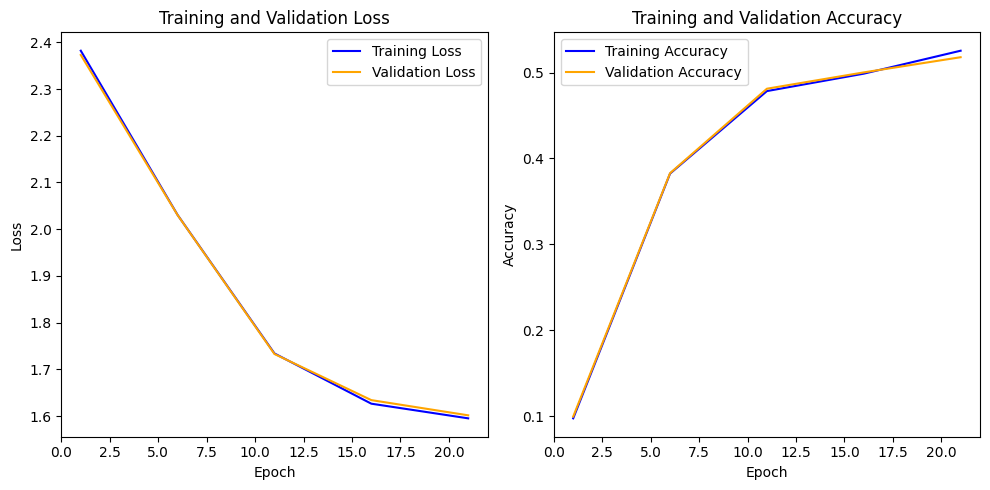

In [ ]:
import matplotlib.pyplot as plt

# Assuming trn_losses_craig, val_losses_craig, tst_losses_craig, trn_acc_craig, val_acc_craig, tst_acc_craig
# are lists containing the respective metrics for each epoch.

# Plot training and validation losses
plt.figure(figsize=(10, 5))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, print_every*len(trn_losses_craig_dp) + 1, print_every), trn_losses_craig_dp, label="Training Loss", color="blue")
plt.plot(range(1, print_every*len(val_losses_craig_dp) + 1, print_every), val_losses_craig_dp, label="Validation Loss", color="orange")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, print_every*len(trn_acc_craig_dp) + 1, print_every), trn_acc_craig_dp, label="Training Accuracy", color="blue")
plt.plot(range(1, print_every*len(val_acc_craig_dp) + 1, print_every), val_acc_craig_dp, label="Validation Accuracy", color="orange")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/260/Plots/results_dp20.png')
plt.show()